In [12]:
# ai_topic_sentiment.py
import re
from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict
from news_retrieval import get_articles

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk


In [2]:

# Download VADER once (creates a local cache)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Theresa\AppData\Roaming\nltk_data...


In [3]:

@dataclass
class Article:
    text: str
    # Optional timestamp; string like "2025-08-01" or pd.Timestamp
    date: Optional[pd.Timestamp] = None
    # Optional id/title to keep track of originals
    id: Optional[str] = None



In [4]:
# --------- Text cleaning (lightweight; let vectorizer do most work) ----------
def basic_clean(s: str) -> str:
    s = re.sub(r'\s+', ' ', s)              # collapse whitespace
    s = s.strip()
    return s


In [5]:

# --------- Topic Modeling ----------------------------------------------------
def fit_topics(
    texts: List[str],
    n_topics: int = 6,
    max_features: int = 30000,
    ngram_range: Tuple[int, int] = (1, 2),
    min_df: int = 2
) -> Tuple[NMF, TfidfVectorizer, List[List[str]]]:
    """
    Returns: (nmf_model, vectorizer, topic_terms)
    """
    vectorizer = TfidfVectorizer(
        stop_words="english",
        lowercase=True,
        ngram_range=ngram_range,
        max_features=max_features,
        min_df=min_df
    )
    X = vectorizer.fit_transform(texts)

    # NMF often gives cleaner, more interpretable topics vs LDA on TF-IDF
    nmf = NMF(n_components=n_topics, random_state=42, init="nndsvda", max_iter=600)
    W = nmf.fit_transform(X)  # doc-topic matrix
    H = nmf.components_       # topic-term matrix

    # top terms per topic for human-readable labels
    feature_names = vectorizer.get_feature_names_out()
    topic_terms: List[List[str]] = []
    for k in range(n_topics):
        top_idx = H[k].argsort()[::-1][:12]
        terms = [feature_names[i] for i in top_idx]
        topic_terms.append(terms)

    return nmf, vectorizer, topic_terms

def assign_topic_labels(topic_terms: List[List[str]], k_top: int = 3) -> List[str]:
    """Create short labels from the top k terms of each topic."""
    labels = []
    for terms in topic_terms:
        label = ", ".join(terms[:k_top])
        labels.append(label)
    return labels

def infer_doc_topics(texts: List[str], nmf: NMF, vectorizer: TfidfVectorizer) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      - doc_topic_df: rows=docs, columns=topic_k, values=weights
      - doc_top_topic: for each doc, the top topic index and weight
    """
    X = vectorizer.transform(texts)
    W = nmf.transform(X)
    doc_topic_df = pd.DataFrame(W, columns=[f"topic_{i}" for i in range(W.shape[1])])
    top_idx = W.argmax(axis=1)
    top_w = W.max(axis=1)
    doc_top_topic = pd.DataFrame({"top_topic_idx": top_idx, "top_topic_weight": top_w})
    return doc_topic_df, doc_top_topic


In [14]:

# --------- Sentiment ---------------------------------------------------------
def compute_sentiments(texts: List[str]) -> pd.Series:
    sia = SentimentIntensityAnalyzer()
    # Use compound score (-1..1)
    return pd.Series([sia.polarity_scores(t)["compound"] for t in texts], name="sent_compound")

# --------- Pipeline ----------------------------------------------------------
# --------- Pipeline ----------------------------------------------------------
def analyze_articles(
    articles: List[dict],
    n_topics: int = 6,
    time_freq: str = "W"  # 'D','W','M' etc.
) -> Dict[str, pd.DataFrame]:
    """
    Main function: returns multiple dataframes you can inspect or export.
    """
    # Build base DataFrame
    df = pd.DataFrame({
        "id": [a['source']['id'] for a in articles],
        "content": [basic_clean(a['content']) for a in articles],
        "date": [pd.to_datetime(a['publishedAt']) if a['publishedAt'] is not None else pd.NaT for a in articles],
    })
    # If no dates provided, use positional index as a pseudo-date (helps trend plots)
    if df["date"].isna().all():
        df["date"] = pd.date_range(start="2000-01-01", periods=len(df), freq="D")

    # Fit topics on all texts
    nmf, vectorizer, topic_terms = fit_topics(df["content"].tolist(), n_topics=n_topics)
    topic_labels = assign_topic_labels(topic_terms, k_top=3)

    # Infer per-doc topics
    doc_topic_df, doc_top_topic = infer_doc_topics(df["content"].tolist(), nmf, vectorizer)
    df = pd.concat([df, doc_topic_df, doc_top_topic], axis=1)
    df["topic_label"] = df["top_topic_idx"].apply(lambda i: topic_labels[i])

    # Sentiment per doc
    df["sent_compound"] = compute_sentiments(df["content"].tolist())

    # Which topics are driving sentiment? (average | mean, and count)
    topic_impact = (
        df.groupby("topic_label")
          .agg(
              mean_sentiment=("sent_compound", "mean"),
              median_sentiment=("sent_compound", "median"),
              articles=("sent_compound", "count")
          )
          .sort_values(["mean_sentiment", "articles"], ascending=[False, False])
          .reset_index()
    )

    # Trends over time per topic
    df["period"] = df["date"].dt.to_period(time_freq).dt.to_timestamp()
    topic_trends = (
        df.groupby(["period", "topic_label"])
          .agg(
              mean_sentiment=("sent_compound", "mean"),
              articles=("sent_compound", "count")
          )
          .reset_index()
          .sort_values(["period", "topic_label"])
    )

    # Also overall sentiment trend (regardless of topic)
    overall_trend = (
        df.groupby("period")
          .agg(mean_sentiment=("sent_compound", "mean"), articles=("sent_compound", "count"))
          .reset_index()
          .sort_values("period")
    )

    # Human-readable topic terms table
    topic_terms_df = pd.DataFrame({
        "topic_idx": list(range(len(topic_terms))),
        "label": topic_labels,
        "top_terms": [", ".join(t) for t in topic_terms]
    })

    return {
        "articles_enriched": df,   # each article with top topic + sentiment
        "topic_terms": topic_terms_df,
        "topic_impact": topic_impact,
        "topic_trends": topic_trends,
        "overall_trend": overall_trend,
    }



In [15]:
# --------- Optional: quick plotting helpers (matplotlib) ---------------------
def plot_overall_trend(overall_trend: pd.DataFrame, title: str = "Overall Sentiment Over Time"):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(overall_trend["period"], overall_trend["mean_sentiment"])
    plt.title(title)
    plt.xlabel("Period")
    plt.ylabel("Mean Sentiment (VADER)")
    plt.tight_layout()
    plt.show()

def plot_topic_trends(topic_trends: pd.DataFrame, topic_subset: Optional[List[str]] = None):
    import matplotlib.pyplot as plt
    if topic_subset is None:
        topic_subset = topic_trends["topic_label"].unique().tolist()
    for label in topic_subset:
        sub = topic_trends[topic_trends["topic_label"] == label]
        plt.figure()
        plt.plot(sub["period"], sub["mean_sentiment"])
        plt.title(f"Sentiment Trend — {label}")
        plt.xlabel("Period")
        plt.ylabel("Mean Sentiment (VADER)")
        plt.tight_layout()
        plt.show()



C:\Users\Theresa\AppData\Local\Temp\ipykernel_34768\1045552068.py:52: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["period"] = df["date"].dt.to_period(time_freq).dt.to_timestamp()


{'articles_enriched':                     id                                            content  \
0                 None  The S&amp;P 500 rose 0.4% on Friday to record ...   
1                 None  Microsoft Corporation (NASDAQ:MSFT) is one of ...   
2                 None  We recently published 10 Stocks Jim Cramer Dis...   
3                 None  The "Magnificent Seven," Nvidia (NVDA), Alphab...   
4                 None  Infosec In Brief North Koreas Lazarus Group ha...   
5                 None  Microsoft Corporation logo on sign-by Jean-Luc...   
6                 None  NurPhoto / Getty Images Arm develops CPU desig...   
7                 None  Photo Illustration by Budrul Chukrut/SOPA Imag...   
8                 None  29 July 2025, Bavaria, Munich: The Microsoft l...   
9                 None  IonQ. Inc. IONQ, a pioneer in quantum computin...   
10                None  Microsoft analysts reboot stock price targets ...   
11                None  Shares of voice AI recognition

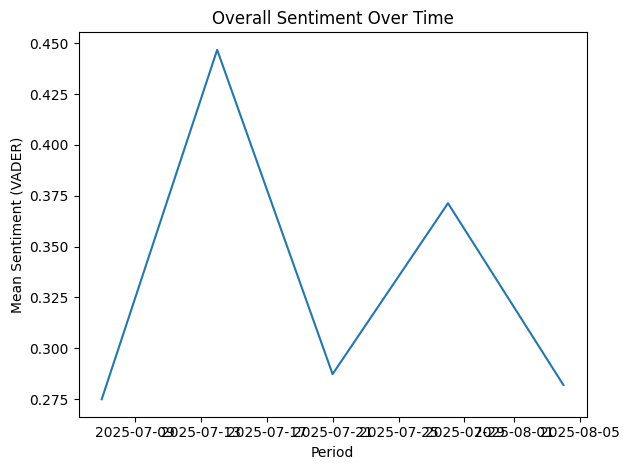

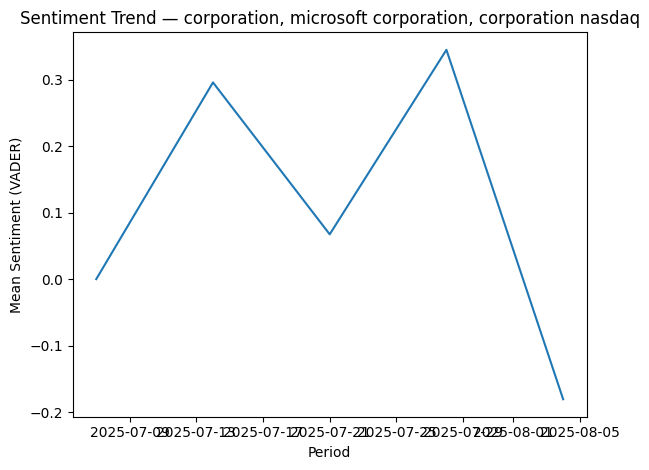

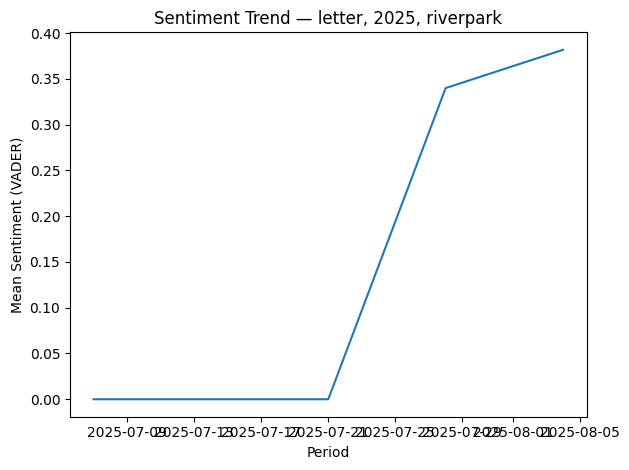

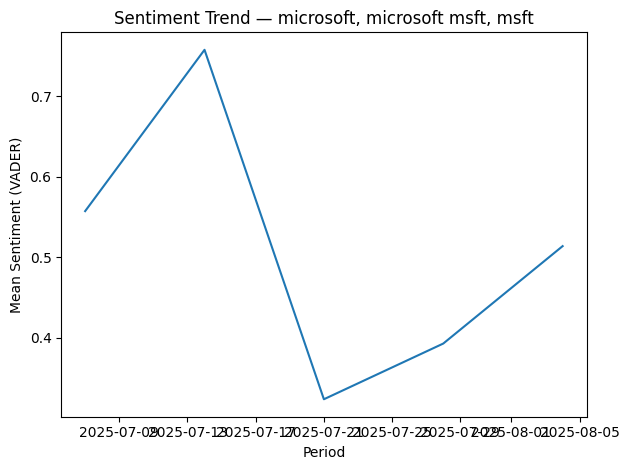

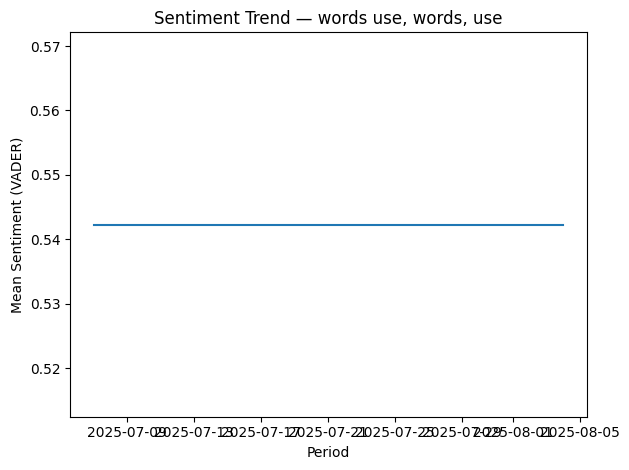

In [20]:
# --------- Example usage -----------------------------------------------------
if True:
    # Replace with your own articles (text + optional date)
    sample_articles = get_articles("MSFT", "2025-07-09", "2025-08-09")

    results = analyze_articles(sample_articles, n_topics=4, time_freq="W")

    print(results)

    print("\n=== Topic terms ===")
    print(results["topic_terms"])

    print("\n=== Top topics driving sentiment (higher mean_sentiment is more positive) ===")
    print(results["topic_impact"])

    print("\n=== Articles (enriched) — first 5 columns ===")
    cols = ["id", "date", "topic_label", "sent_compound"]
    print(results["articles_enriched"][cols])

    # Optional plots:
    plot_overall_trend(results["overall_trend"])
    plot_topic_trends(results["topic_trends"])
